https://habr.com/ru/articles/588270/

Шум -> Сезонность -> Цикличность -> Тренд

In [3]:
import matplotlib.pyplot as plt
from math import sin
import numpy as np

import colorednoise as cn

In [4]:
# Generals variables
length = 30
resolution = 20

time = np.arange(length * resolution)

# Noise

случайный дрейф, фликкер-шум

In [5]:
def noised(func, k=0.3, prob=0.03, jump=7):
    o = []
    for p in func:
        r = (np.random.random() * 2 - 1) * k

        # Standard noise and random emissions
        if np.random.random() < prob:
            c = p + r * jump
        else:
            c = p + r

        o.append(c)
    return o

In [6]:
beta = 1  # beta=1 для розового шума (1/f)
flicker_noise = cn.powerlaw_psd_gaussian(beta, length * resolution)

# Seasonality

A seasonal pattern occurs when a time series is affected by seasonal factors such as the time of the year or the day of the week. Seasonality is always of a fixed and known period. The monthly sales of antidiabetic drugs (Figure 2.2) shows seasonality which is induced partly by the change in the cost of the drugs at the end of the calendar year. (Note that one series can have more than one seasonal pattern.)

Бороться мы будем с двумя видами шума: постоянный шум (аддитивный белый гауссовский шум или АБГШ) с относительно стабильной амплитудой и случайные импульсы, вызванные внешними факторами. Амплитудой шума - стандартное отклонение зашумленного сигнала от не зашумленного.

Симулировать это мы будем данным образом.

In [7]:
seasonality = 10 * np.sin(2 * np.pi * time / 12) + 5 * np.cos(2 * np.pi * time / 4)

# Цикличность

A cycle occurs when the data exhibit rises and falls that are not of a fixed frequency. These fluctuations are usually due to economic conditions, and are often related to the “business cycle”. The duration of these fluctuations is usually at least 2 years.

https://otexts.com/fpp3/tspatterns.html

Фильтрация шума очень важная вещь, при работе с различными датчиками. Сигнал, получаемый от них всегда приходит с шумами, и важно уметь их грамотно отфильтровать. Качественная фильтрация шума способна уменьшить погрешность и увеличить качество измерения датчика. Этим мы сегодня и займемся.

Примерами будут три графика - синусоида, квадратный сигнал (или дискретный, или цифровой) и треугольный сигнал (или пилообразный).

In [43]:
# Creating arrays with graphic

scale = 30

sinus_g = scale * np.array([sin(i / resolution) for i in range(length * resolution)])

square_g = scale * np.array([(1 if p > 0 else -1) for p in sinus_g])

triangle_g = []
t = -1
for _ in range(length * resolution):
    t = t + 0.035 if t < 1 else -1
    triangle_g.append(t)

triangle_g = scale * np.array(triangle_g)

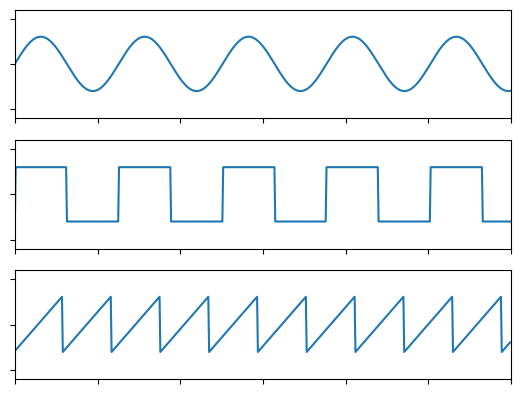

In [ ]:
# Output of graphs

graphics = [sinus_g, square_g, triangle_g]

fig, axs = plt.subplots(3, 1)

for i in range(len(graphics)):
    axs[i].plot(graphics[i])

    (
        axs[i].set_ylim([-2 * scale, 2 * scale]),
        axs[i].set_xlim([0, length * resolution]),
    )
    axs[i].set_yticklabels([]), axs[i].set_xticklabels([])

plt.show()

# Тренд

A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear. Sometimes we will refer to a trend as “changing direction”, when it might go from an increasing trend to a decreasing trend.

Такое ощущение, что тренд - это все, что не умещается во все предыдущие опреления. Ведь тренд может быть и линейным, и нелинейным, и немонотонным

In [ ]:
# линейный

trend_linear = 100 + 0.5 * time

# нелинейный
trend_nonlinear = 0.0005 * (time - 100) ** 2 + 0.005 * time

# Mixing it all

In [103]:
noise = flicker_noise * 10
seasonality = seasonality
cycles = sinus_g
trend = trend_nonlinear

components = np.array([noise, seasonality, cycles, trend])

ts = np.sum(components, axis=0)  # np.product for multiplicative effect

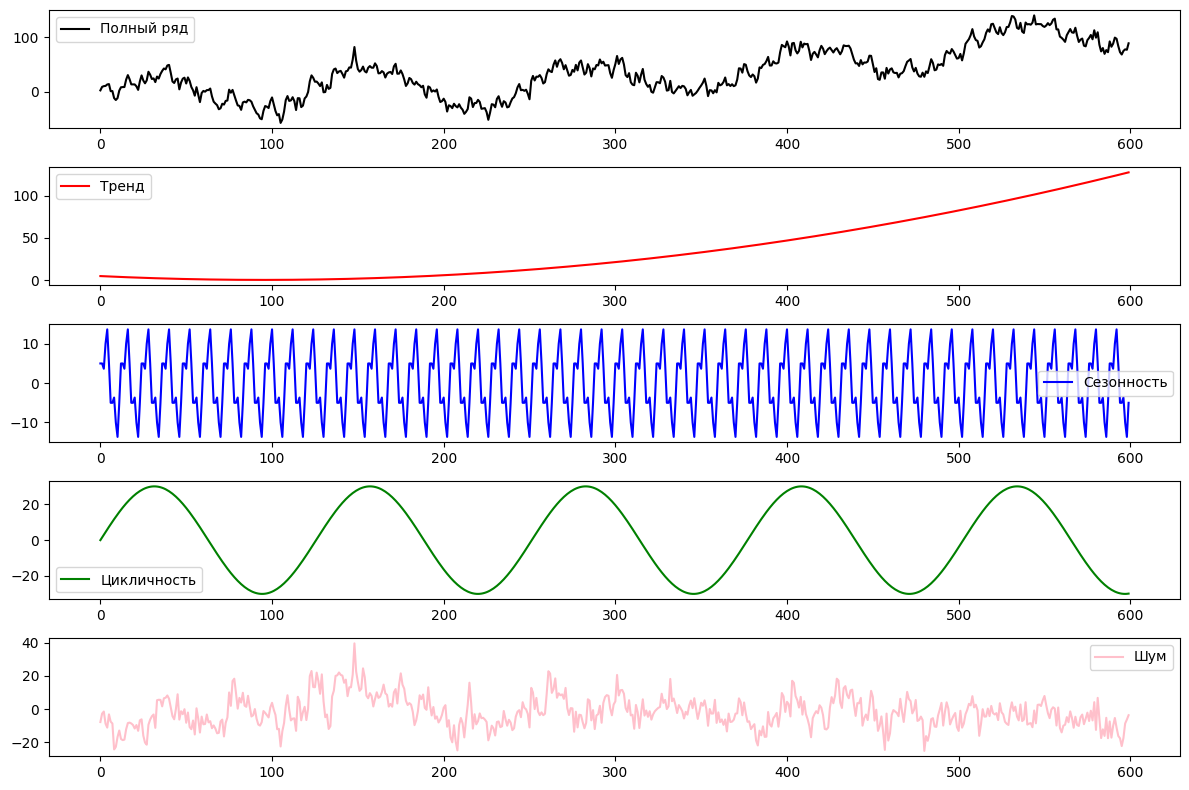

In [107]:
plt.figure(figsize=(12, 8))
plt.subplot(511)
plt.plot(time, ts, label="Полный ряд", color="black")
plt.legend()

plt.subplot(512)
plt.plot(time, trend, label="Тренд", color="red")
plt.legend()

plt.subplot(513)
plt.plot(time, seasonality, label="Сезонность", color="blue")
plt.legend()

plt.subplot(514)
plt.plot(time, cycles, label="Цикличность", color="green")
plt.legend()

plt.subplot(515)
plt.plot(time, noise, label="Шум", color="pink")
plt.legend()

plt.tight_layout()
plt.show()

## Наивные методы прогнозирования

### Наивный метод

For naïve forecasts, we simply set all forecasts to be the value of the last observation. That is,

$$

\^{y}_{T+h|T} = {y}_{T}
$$

This method works remarkably well for many economic and financial time series.

### Среднее арифметическое
Как по мне, самый очевидный способ минимизировать шум. Для его реализации потребуется ввести буфер нескольких предыдущих значений, каждый раз, когда опрашивается датчик буфер сдвигается (первый элемент удаляется, а новое значение датчика добавляется в конец или как-нибудь по другому, главное фиксированный размер буфера). От его размера и будет зависеть результат и быстродействие кода. С фильтрацией алгоритм справляется очень неплохо. Но его проблема заключается в производительности. Контроллеру приходится делать множество вычислений с плавающей точкой, что может сказаться на скорости выполнения кода. Но если датчик не следует очень часто опрашивать, то этот метод отлично подойдет.

In [105]:
def arith_mean(f, buffer_size=10):
    # Creating buffer
    if not hasattr(arith_mean, "buffer"):
        arith_mean.buffer = [f] * buffer_size

    # Move buffer to actually values ( [0, 1, 2, 3] -> [1, 2, 3, 4] )
    arith_mean.buffer = arith_mean.buffer[1:]
    arith_mean.buffer.append(f)

    # Calculation arithmetic mean
    mean = 0
    for e in arith_mean.buffer:
        mean += e
    mean /= len(arith_mean.buffer)

    return mean


Как мы видим, при увеличении буфера квадратный и треугольный сигналы сильно исказились, а синусоида сместилась. Проявляется запаздывание среднего значения. Так что, при использовании данного фильтра стоит аккуратнее подбирать размер буфера.

### Медианный фильтр
Медианный фильтр предназначен справляться со случайными импульсами. Если среднее арифметическое получая на вход (10, 12, 55), выдаст 25.67, то медиан выдаст 12. На первый взгляд не так просто понять как он устроен, но со своей задачей он справляется отлично. На просторах интернета я нашел лаконичное исполнение. Но оно подойдет только в случаях когда длительность импульса не более одного шага, иначе придется использовать другое исполнение медианы высшего порядка.

In [106]:
def median(f):
    # Creating buffer
    if not hasattr(median, "buffer"):
        median.buffer = [f] * 3

    # Move buffer to actually values ( [0, 1, 2] -> [1, 2, 3] )
    median.buffer = median.buffer[1:]
    median.buffer.append(f)

    # Calculation median
    a = median.buffer[0]
    b = median.buffer[1]
    c = median.buffer[2]
    middle = max(a, c) if (max(a, b) == max(b, c)) else max(b, min(a, c))

    return middle

Медианный фильтр справился почти со всеми импульсами. К тому же этот алгоритм совершенно прост в вычислении. И используя его в комбинации с каким-либо другим другим фильтром можно получить максимальный результат.

### Экспоненциальное бегущее среднее и адаптивный коэффициент
Этот фильтр по своей сути схож с первым, а главное он более простой по вычислениям. Работает он так: к предыдущему фильтрованному значению прибавляется новое, и каждое из них помножено на собственный коэффициент, сумма которых равна 1. Коэффициент k подбирается от 0 до 1 и означает важность нового значения по сравнению с предыдущем, то есть чем больше k, тем больше важность нового нефильтрованного значения и фильтрованный график ближе к изначальному.